In [86]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
import fitsio
from tqdm import tqdm

from astroquery.jplhorizons import Horizons

from tess_ephem import ephem, TessEphem, log
from tess_asteroid_ml import *
from ipywidgets import *

In [3]:
path = "/Volumes/ADAP-Kepler/Work/BAERI/data/tess/ffi"
cutout_size = 50

In [4]:
def _load_ffi_image(
    telescope,
    fname,
    extension,
    cutout_size=None,
    cutout_origin=[0, 0],
    return_coords=False,
):
    """
    Use fitsio to load an image and return positions and flux values.
    It can do a smal cutout of size `cutout_size` with a defined origin.

    Parameters
    ----------
    telescope: str
        String for the telescope
    fname: str
        Path to the filename
    extension: int
        Extension to cut out of the image
    cutout_size : int
        Size of the cutout in pixels (e.g. 200)
    cutout_origin : tuple of ints
        Origin coordinates in pixels from where the cutout stars. Pattern is
        [row, column].
    return_coords : bool
        Return or not pixel coordinates.

    Return
    ------
    f: np.ndarray
        Array of flux values read from the file. Shape is [row, column].
    col_2d: np.ndarray
        Array of column values read from the file. Shape is [row, column]. Optional.
    row_2d: np.ndarray
        Array of row values read from the file. Shape is [row, column]. Optional.
    """
    f = fitsio.FITS(fname)[extension]
    if telescope.lower() == "kepler":
        # CCD overscan for Kepler
        r_min = 20
        r_max = 1044
        c_min = 12
        c_max = 1112
    elif telescope.lower() == "tess":
        # CCD overscan for TESS
        r_min = 0
        r_max = 2048
        c_min = 44
        c_max = 2092
    else:
        raise TypeError("File is not from Kepler or TESS mission")

    # If the image dimension is not the FFI shape, we change the r_max and c_max
    dims = f.get_dims()
    if dims == [r_max, c_max]:
        r_max, c_max = np.asarray(dims)
    r_min += cutout_origin[0]
    c_min += cutout_origin[1]
    if (r_min > r_max) | (c_min > c_max):
        raise ValueError("`cutout_origin` must be within the image.")
    if cutout_size is not None:
        r_max = np.min([r_min + cutout_size, r_max])
        c_max = np.min([c_min + cutout_size, c_max])
    if return_coords:
        row_2d, col_2d = np.mgrid[r_min:r_max, c_min:c_max]
        return col_2d, row_2d, f[r_min:r_max, c_min:c_max]
    return f[r_min:r_max, c_min:c_max]

In [5]:
sector = 43
camera = 3
ccd = 3
scc_str = f"s{sector:04}-{camera}-{ccd}"
scc_str

's0043-3-3'

In [6]:
ffi = fits.open(f"{path}/sector{sector:04}/tess2021276084859-{scc_str}-0214-s_ffic.fits")
wcs = WCS(ffi[1])

Set MJD-END to 59490.377139 from DATE-END'. [astropy.wcs.wcs]


In [89]:
ffi[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2021-10-16'         / file creation date.                            
TSTART  =    2490.870995967270 / observation start time in BTJD                 
TSTOP   =    2490.877940177169 / observation stop time in BTJD                  
DATE-OBS= '2021-10-03T08:53:

In [93]:
date_obs = Time([ffi[0].header["DATE-OBS"], ffi[0].header["DATE-END"]])
date_obs.mean().isot

'2021-10-03T08:58:04.858'

In [7]:
col_2d, row_2d, f2d = _load_ffi_image(
                "TESS",
                f"{path}/sector{sector:04}/tess2021276084859-{scc_str}-0214-s_ffic.fits",
                1,
                None,
                [0, 0],
                return_coords=True,
            )
ra_2d, dec_2d = wcs.all_pix2world(np.vstack([col_2d.ravel(), row_2d.ravel()]).T, 0.0).T
ra_2d = ra_2d.reshape(col_2d.shape)
dec_2d = dec_2d.reshape(col_2d.shape)

In [94]:
ffi_coord = SkyCoord(ra_2d*u.deg, dec_2d*u.deg, frame='icrs', obstime=date_obs.mean().isot)

In [104]:
print(ffi_coord.ra.min().hms, ffi_coord.ra.max().hms)
print(ffi_coord.dec.min().dms, ffi_coord.dec.max().dms)
print(ffi_coord.obstime.jd)

hms_tuple(h=4.0, m=9.0, s=46.40615811081638) hms_tuple(h=5.0, m=3.0, s=56.795776488808585)
dms_tuple(d=9.0, m=51.0, s=34.66310726086178) dms_tuple(d=23.0, m=5.0, s=30.526061721026565)
2459490.873667338


<Angle 62.44335899 deg>

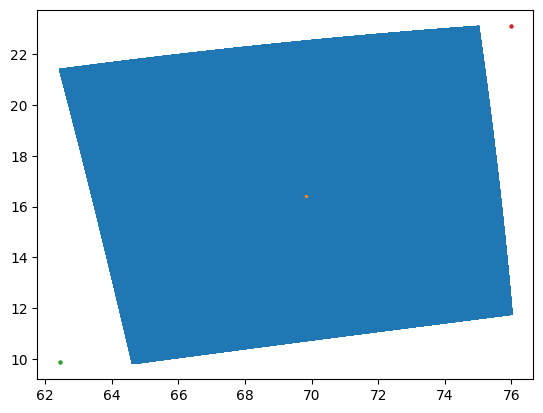

In [159]:
plt.scatter(ra_2d, dec_2d, s=1)
plt.scatter(ra_2d[1000, 1000], dec_2d[1000, 1000], s=2)
plt.scatter(ra_2d.min(), dec_2d.min(), s=5)
plt.scatter(ra_2d.max(), dec_2d.max(), s=5)
plt.scatter(ra_2d.min(), dec_2d.min(), s=5)
plt.show()

In [ ]:
jpl_sbi = ""

if os.path.isfile(jpl_sbi):
    jpl_sb = pd.read_csv(f"{os.path.dirname(PACKAGEDIR)}/data/jpl_data/jpl_small_bodies_tess_{scc_str}_results.csv")
    
else:
    from sbident import SBIdent

    #get state of TESS (-95) from Horizons at our observation time
    #and convert it from [AU, AU/day] to [km, km/s]
    # location 500 is geocentric, minor planet center.
    # 500@-95 means Geocentric location to TESS

    au = (1 * u.au).to(u.km).value #1AU in km
    tess = Horizons(id='-95', location='500', epochs=date_obs.jd.mean(), id_type=None).vectors(refplane='earth') #state vector
    tess_km = tess[['x','y','z','vx','vy','vz']].to_pandas().to_numpy() * au #convert to km/d
    tess_km[:,3:] = tess_km[:,3:] / 86400 #convert to km/s
    tess_km = tess_km[0] #take the first row

    #form the xobs dictionary that is the input for SBIdent location argument
    xobs = ','.join([np.format_float_scientific(s,precision=5) for s in tess_km])
    xobs_location = {'xobs': xobs}


    edge1 = SkyCoord(ra_2d.min() * u.deg, dec_2d.min() * u.deg, frame='icrs')
    edge2 = SkyCoord(ra_2d.max() * u.deg, dec_2d.max() * u.deg, frame='icrs')

    sbid3 = SBIdent(location=xobs_location, obstime=date_obs.mean(), fov=[edge1, edge2], maglim=20, precision="high", request=True)

    jpl_sb = sbid3.results.to_pandas()

    
# parse columns
jpl_sb["Astrometric Dec. (dd mm′ss.s″)"] = [x.replace(" ",":").replace("\'",":").replace('"', "") 
                                            for x in jpl_sb["Astrometric Dec. (dd mm′ss.s″)"]]
coord = SkyCoord(jpl_sb[["Astrometric R.A. (hh:mm:ss.ss)", "Astrometric Dec. (dd mm′ss.s″)"]].values, 
         frame='icrs', 
         unit=(u.hourangle, u.deg))
jpl_sb["ra"] = coord.ra.deg
jpl_sb["dec"] = coord.dec.deg
jpl_sb["V_mag"] = jpl_sb["Visual magnitude (V)"].replace("n.a.", np.nan).astype(np.float64)
jpl_sb["name"] = jpl_sb["Object name"].apply(
    lambda x: x.split("(")[0].strip()
)
jpl_sb["id"] = jpl_sb["Object name"].apply(
    lambda x: x.split("(")[1][:-1].strip() if len(x.split("(")) > 1 else x.split("(")[0].strip()
)
jpl_sb

In [180]:
sbid3.results.to_pandas()

,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)"
0,1 Ceres (A801 AA),04:44:20.71,"+16 02'37.7""",6.E3,-2.E3,6651.,8.23,3.560E+00,2.079E+00
1,85 Io (A865 SA),04:45:43.50,"+14 40'15.2""",8.E3,-6.E3,1.0E4,12.4,4.773E+00,-1.506E+01
2,145 Adeona (A875 LB),04:18:34.75,"+12 01'41.9""",-2.E4,-2.E4,2.3E4,12.7,-3.679E-02,1.623E+00
3,288 Glauke (A890 DA),04:35:24.12,"+17 04'13.6""",-1.E3,2.E3,2482.,15.4,-1.894E+00,-2.855E+00
4,311 Claudia (A891 LA),04:19:22.51,"+19 13'56.5""",-2.E4,1.E4,1.8E4,15.0,-2.161E+00,3.276E-02
...,...,...,...,...,...,...,...,...,...
1369,594782 Kacperwierzchos (2017 YV15),04:31:16.64,"+13 00'19.0""",-5.E3,-1.E4,1.3E4,19.9,1.848E+01,-6.103E+00
1370,(2003 UW26),04:09:39.60,"+20 27'28.5""",-2.E4,1.E4,2.7E4,20.0,-8.019E+00,9.146E+01
1371,(2010 GR72),04:27:50.30,"+21 45'25.2""",-8.E3,2.E4,2.1E4,18.8,6.912E+00,-2.576E+01
1372,(2021 PL23),04:34:13.89,"+21 16'07.9""",-2.E3,2.E4,1.7E4,18.6,4.584E+02,-2.456E+02


In [10]:
jpl_sb = pd.read_csv(f"{os.path.dirname(PACKAGEDIR)}/data/jpl_data/jpl_small_bodies_tess_{scc_str}_results.csv")
jpl_sb["Astrometric Dec. (dd mm′ss.s″)"] = [x.replace(" ",":").replace("\'",":").replace('"', "") 
                                            for x in jpl_sb["Astrometric Dec. (dd mm′ss.s″)"]]
coord = SkyCoord(jpl_sb[["Astrometric R.A. (hh:mm:ss.ss)", "Astrometric Dec. (dd mm′ss.s″)"]].values, 
         frame='icrs', 
         unit=(u.hourangle, u.deg))
jpl_sb["ra"] = coord.ra.deg
jpl_sb["dec"] = coord.dec.deg
jpl_sb["V_mag"] = jpl_sb["Visual magnitude (V)"].replace("n.a.", np.nan).astype(np.float64)
jpl_sb["name"] = jpl_sb["Object name"].apply(
    lambda x: x.split("(")[0].strip()
)
jpl_sb["id"] = jpl_sb["Object name"].apply(
    lambda x: x.split("(")[1][:-1].strip() if len(x.split("(")) > 1 else x.split("(")[0].strip()
)
jpl_sb

,Object name,Astrometric R.A. (hh:mm:ss.ss),Astrometric Dec. (dd mm′ss.s″),RA center dist. (″),Dec. center dist. (″),Norm center dist. (″),Visual magnitude (V),RA rate (″/h),Dec. rate (″/h),Unnamed: 9,Unnamed: 10,ra,dec,V_mag,name,id
0,1 Ceres (A801 AA),04:43:28.24,+15:56:53.0,6000.0,-2000.0,6000.0,8.3,14.0,4.00,1,a0000001,70.867667,15.948056,8.3,1 Ceres,A801 AA
1,85 Io (A865 SA),04:44:38.54,+15:03:22.5,7000.0,-5000.0,8500.0,12.4,17.0,-12.00,85,a0000085,71.160583,15.056250,12.4,85 Io,A865 SA
2,145 Adeona (A875 LB),04:18:06.00,+11:56:30.4,-20000.0,-20000.0,23000.0,12.8,13.0,4.20,145,a0000145,64.525000,11.941778,12.8,145 Adeona,A875 LB
3,288 Glauke (A890 DA),04:35:14.84,+17:07:04.4,-1000.0,2000.0,2700.0,15.5,7.4,-0.89,288,a0000288,68.811833,17.117889,15.5,288 Glauke,A890 DA
4,311 Claudia (A891 LA),04:19:12.84,+19:11:15.4,-20000.0,10000.0,18000.0,15.1,8.5,2.50,311,a0000311,64.803500,19.187611,15.1,311 Claudia,A891 LA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18383,C/2018 L2 (ATLAS),04:42:24.65,+15:16:24.0,5000.0,-4000.0,6500.0,21.9,-4.4,-4.90,2018 L2,dK18L020,70.602708,15.273333,21.9,C/2018 L2,ATLAS
18384,C/2019 D1 (Flewelling),05:01:49.96,+10:45:48.3,20000.0,-20000.0,30000.0,25.2,-2.2,-5.20,2019 D1,dK19D010,75.458167,10.763417,25.2,C/2019 D1,Flewelling
18385,P/2019 S2 (PANSTARRS),04:58:30.70,+17:03:18.8,20000.0,2000.0,19000.0,23.3,3.7,0.43,2019 S2,dK19S020,74.627917,17.055222,23.3,P/2019 S2,PANSTARRS
18386,C/2020 T5 (Lemmon),04:52:47.08,+13:51:47.3,10000.0,-9000.0,17000.0,25.9,-6.5,-20.00,2020 T5,dK20T050,73.196167,13.863139,25.9,C/2020 T5,Lemmon


In [11]:
jpl_sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18388 entries, 0 to 18387
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Object name                     18388 non-null  object 
 1   Astrometric R.A. (hh:mm:ss.ss)  18388 non-null  object 
 2   Astrometric Dec. (dd mm′ss.s″)  18388 non-null  object 
 3   RA center dist. (″)             18388 non-null  float64
 4   Dec. center dist. (″)           18388 non-null  float64
 5   Norm center dist. (″)           18388 non-null  float64
 6   Visual magnitude (V)            18388 non-null  object 
 7   RA rate (″/h)                   18388 non-null  float64
 8   Dec. rate (″/h)                 18388 non-null  float64
 9   Unnamed: 9                      18388 non-null  object 
 10  Unnamed: 10                     18388 non-null  object 
 11  ra                              18388 non-null  float64
 12  dec                             

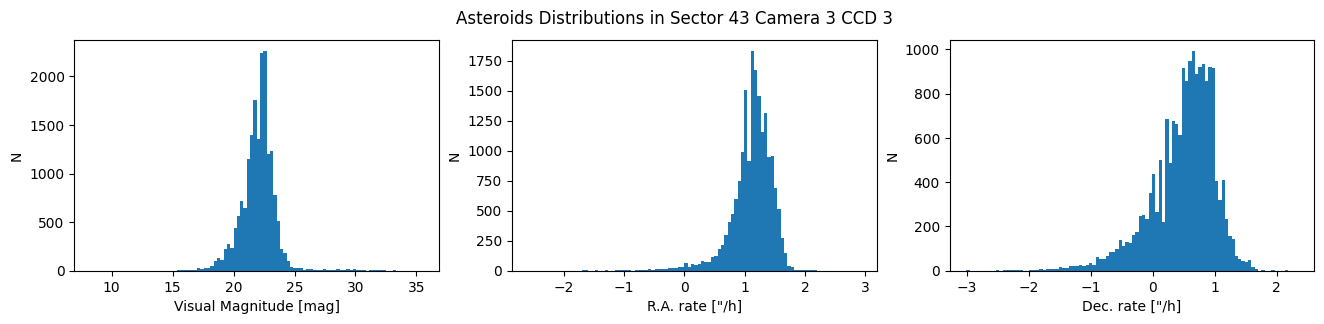

In [12]:
fig, ax = plt.subplots(1,3,figsize=(16,3))
fig.suptitle(f"Asteroids Distributions in Sector {sector} Camera {camera} CCD {ccd}")
ax[0].hist(jpl_sb["V_mag"].values, bins=100)
ax[0].set_xlabel("Visual Magnitude [mag]")
ax[0].set_ylabel("N")
ax[1].hist(np.log10(np.abs(jpl_sb["RA rate (″/h)"].values)), bins=100, log=False)
ax[1].set_xlabel("R.A. rate [\"/h]")
ax[1].set_ylabel("N")
ax[2].hist(np.log10(np.abs(jpl_sb["Dec. rate (″/h)"].values)), bins=100, log=False)
ax[2].set_xlabel("Dec. rate [\"/h]")
ax[2].set_ylabel("N")
plt.show()

In [13]:
jpl_sb_bright = jpl_sb.query("V_mag <= 18")

In [14]:
jpl_sb_bright

,Object name,Astrometric R.A. (hh:mm:ss.ss),Astrometric Dec. (dd mm′ss.s″),RA center dist. (″),Dec. center dist. (″),Norm center dist. (″),Visual magnitude (V),RA rate (″/h),Dec. rate (″/h),Unnamed: 9,Unnamed: 10,ra,dec,V_mag,name,id
0,1 Ceres (A801 AA),04:43:28.24,+15:56:53.0,6000.0,-2000.0,6000.0,8.3,14.0,4.00,1,a0000001,70.867667,15.948056,8.3,1 Ceres,A801 AA
1,85 Io (A865 SA),04:44:38.54,+15:03:22.5,7000.0,-5000.0,8500.0,12.4,17.0,-12.00,85,a0000085,71.160583,15.056250,12.4,85 Io,A865 SA
2,145 Adeona (A875 LB),04:18:06.00,+11:56:30.4,-20000.0,-20000.0,23000.0,12.8,13.0,4.20,145,a0000145,64.525000,11.941778,12.8,145 Adeona,A875 LB
3,288 Glauke (A890 DA),04:35:14.84,+17:07:04.4,-1000.0,2000.0,2700.0,15.5,7.4,-0.89,288,a0000288,68.811833,17.117889,15.5,288 Glauke,A890 DA
4,311 Claudia (A891 LA),04:19:12.84,+19:11:15.4,-20000.0,10000.0,18000.0,15.1,8.5,2.50,311,a0000311,64.803500,19.187611,15.1,311 Claudia,A891 LA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,48955 (1998 QE23),04:44:25.63,+21:17:14.6,7000.0,20000.0,18000.0,18.0,35.0,9.00,48955,a0048955,71.106792,21.287389,18.0,48955,1998 QE23
863,52439 (1994 QL),04:08:48.35,+10:13:56.9,-20000.0,-20000.0,33000.0,17.6,3.2,41.00,52439,a0052439,62.201458,10.232472,17.6,52439,1994 QL
1134,71102 (1999 XH144),04:50:34.57,+17:33:01.6,10000.0,4000.0,12000.0,17.9,28.0,17.00,71102,a0071102,72.644042,17.550444,17.9,71102,1999 XH144
1215,75223 Wupatki (1999 WP1),04:21:39.82,+17:11:52.1,-10000.0,3000.0,13000.0,18.0,34.0,5.90,75223,a0075223,65.415917,17.197806,18.0,75223 Wupatki,1999 WP1


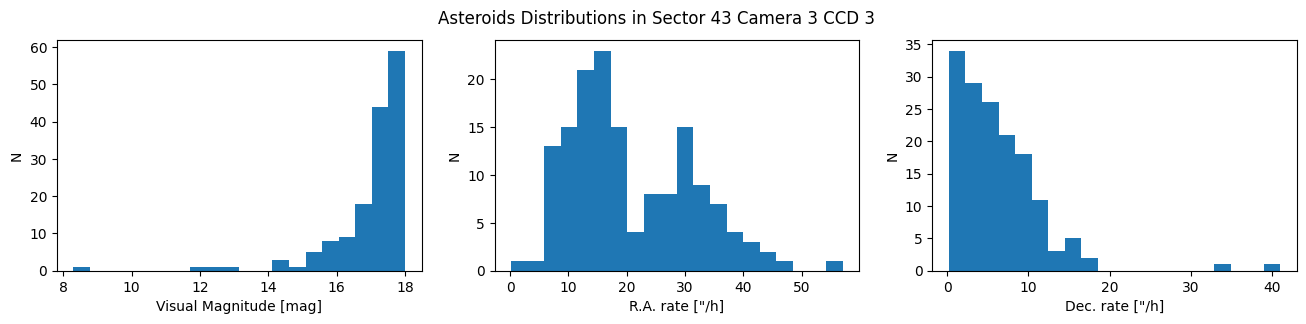

In [15]:
fig, ax = plt.subplots(1,3,figsize=(16,3))
fig.suptitle(f"Asteroids Distributions in Sector {sector} Camera {camera} CCD {ccd}")
ax[0].hist(jpl_sb_bright["V_mag"].values, bins=20)
ax[0].set_xlabel("Visual Magnitude [mag]")
ax[0].set_ylabel("N")
ax[1].hist(np.abs(jpl_sb_bright["RA rate (″/h)"].values), bins=20, log=False)
ax[1].set_xlabel("R.A. rate [\"/h]")
ax[1].set_ylabel("N")
ax[2].hist(np.abs(jpl_sb_bright["Dec. rate (″/h)"].values), bins=20, log=False)
ax[2].set_xlabel("Dec. rate [\"/h]")
ax[2].set_ylabel("N")
plt.show()

In [16]:
def in_cutout(cutout_col, cutout_row, asteroid_col, asteroid_row):
    is_in = ((asteroid_col >= cutout_col.min() - 2) & 
             (asteroid_col <= cutout_col.max() + 2) & 
             (asteroid_row >= cutout_row.min() - 2) & 
             (asteroid_row <= cutout_row.max() + 2))
    return is_in.any()

In [17]:
f"{ra_2d[1000, 900]:.4f} +{dec_2d[1000, 900]:.4f}"

'69.8983 +15.8346'

In [65]:
fficut_aster = AsteroidTESScut(f"{ra_2d[1000, 900]:.4f} {dec_2d[1000, 900]:.4f}", 
                               sector=sector, 
                               cutout_size=50)
fficut_aster.ffi_exp_time = ffi[1].header["EXPOSURE"]*24*3600

Querying TESScut


In [66]:
# sb_ephems_lowres = {}

In [67]:
time_step = 100
jpl_sb_bright["query_name"] = None

for k, row in tqdm(jpl_sb_bright.iterrows(), total=len(jpl_sb_bright)):
    if k not in sb_ephems_lowres.keys():
        # query JPL to get asteroid track within sector times ever 12h
        try:
            te = TessEphem(row['id'], 
                            start=fficut_aster.tpf.time[0], 
                            stop=fficut_aster.tpf.time[-1], 
                            step="12H", 
                            id_type="smallbody",
                            )
            name_ok = row['id']
        except ValueError:
            te = TessEphem(row['name'], 
                           start=fficut_aster.tpf.time[0], 
                           stop=fficut_aster.tpf.time[-1], 
                           step="12H", 
                           id_type="smallbody",
                           )
            name_ok = row['name']
        # predict asteroid position in the sector with low res
        ephems_aux = te.predict(time=fficut_aster.tpf.time[::time_step], 
                                aberrate=True, 
                                verbose=False,
                               )
        ephems_aux = ephems_aux.query(f"camera == {camera} and ccd == {ccd}")
        if len(ephems_aux) == 0:
            continue
        sb_ephems_lowres[k] = ephems_aux
        jpl_sb_bright.loc[k, "query_name"] = name_ok

/var/folders/lz/gmp0cdwx3_v5v7qww7r6sg100000gn/T/ipykernel_97949/823051033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jpl_sb_bright["query_name"] = None
100%|███████████████████████████████████████████████████████████████████████████████| 151/151 [00:34<00:00,  4.38it/s]


In [68]:
sb_ephems_lowres[8]

,sector,camera,ccd,column,row
time,,,,,
2474.1715562889494,43,3,3,1605.080735,276.056574
2474.8660704825543,43,3,3,1600.987306,255.018294
2475.5605839413483,43,3,3,1596.395442,236.169422
2476.2550963886124,43,3,3,1591.364506,218.503590
2476.9496079422743,43,3,3,1586.009562,201.642188
2477.6441187191,43,3,3,1580.395055,185.427024
2478.3386287629764,43,3,3,1574.565400,169.770952
2479.033138131299,43,3,3,1568.550184,154.626224
2479.7276468510727,43,3,3,1562.364768,139.955220


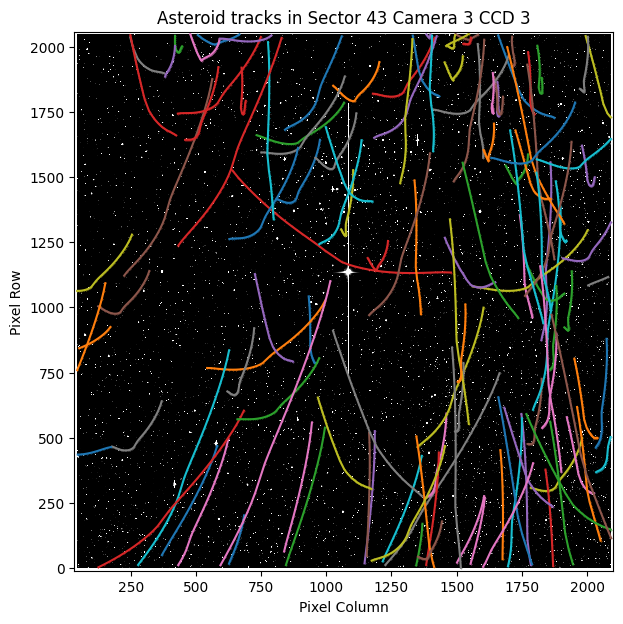

In [69]:
plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
# plt.scatter(col_2d, row_2d, s=1, c=f2d, vmin=500, vmax=5000)
plt.pcolormesh(col_2d, row_2d, f2d, vmin=400, vmax=2000, cmap="Greys_r")
# plt.scatter(fficut_aster.column, fficut_aster.row, s=1, label="TESScut", c="k")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    plt.plot(val.column, val.row, ".-", ms=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [70]:
sampling = "tiled"

In [71]:
if sampling == "tiled":
    dx = 2
    xcen = np.arange(0 + dx, len(col_2d) - dx, 50)
    ycen = np.arange(0 + dx, len(row_2d) - dx, 50)
    xcen, ycen = np.meshgrid(xcen, ycen)
elif sampling == "random":
    ncuts = 20
    xcen, ycen = np.random.randint(0 + dx, len(col_2d) - dx, (2, ncuts))
    xcen, ycen = np.meshgrid(xcen, ycen)
else:
    raise NotImplementedError

<Axes: title={'center': 'Target ID: 69.8983 +15.8346, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

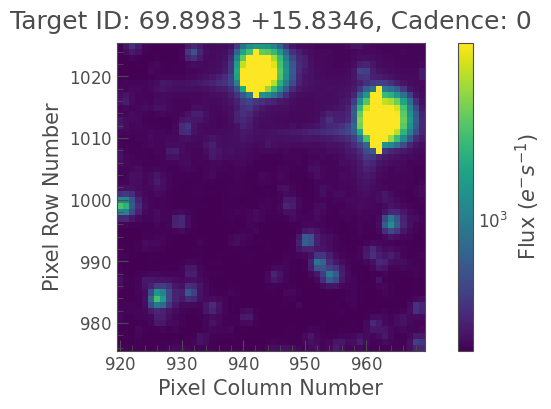

In [73]:
fficut_aster.tpf.plot(scale="log")

In [75]:
fficut_aster.get_CBVs(align=False, interpolate=True)

Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero


<Axes: title={'center': 'TESS CBVs (Sector.Camera.CCD : 43.3.3, CBVType.Band : MultiScale.2)'}, xlabel='Time [btjd]'>

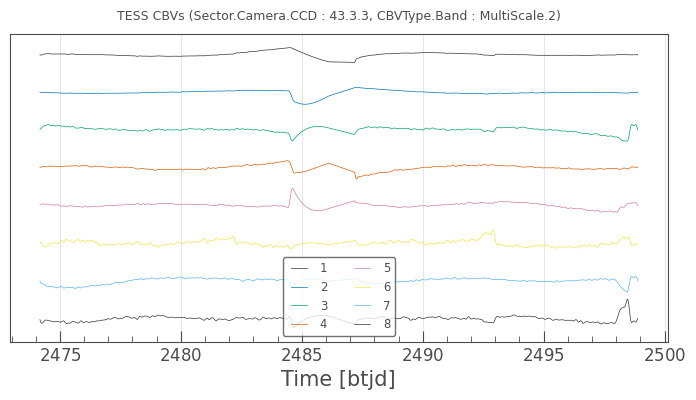

In [76]:
fficut_aster._cbvs.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

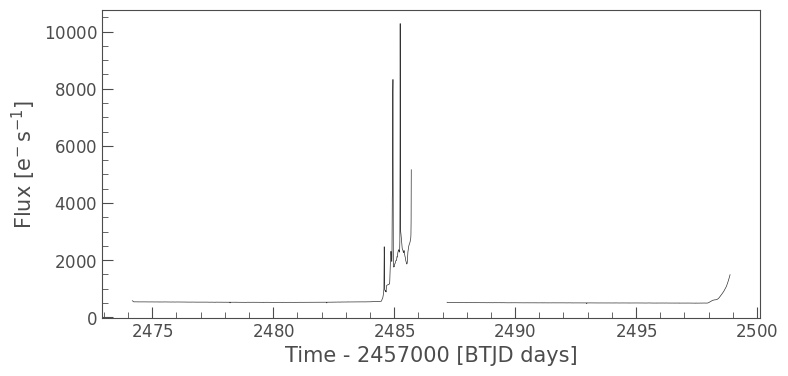

In [77]:
fficut_aster.tpf.to_lightcurve().plot()

In [31]:
sb_ephems_highres = {}

In [78]:
# del fficut_aster.asteroid_mask

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    # check if asteroid track passes over the TESScut
    is_in = in_cutout(fficut_aster.column, 
                      fficut_aster.row, 
                      sb_ephems_lowres[k].column.values, 
                      sb_ephems_lowres[k].row.values
                     )
    if is_in:
        print("Asteroid in cutout: ", jpl_sb_bright.loc[k, "query_name"])
        # predict full res track
        if k not in sb_ephems_highres.keys():
            te = TessEphem(jpl_sb_bright.loc[k, "query_name"], 
                               start=fficut_aster.tpf.time[0], 
                               stop=fficut_aster.tpf.time[-1], 
                               step="12H", 
                               id_type="smallbody",
                               )
            sb_ephems_highres[k] = te.predict(time=fficut_aster.tpf.time, 
                                              aberrate=True, 
                                              verbose=True,
                                             )
        source_rad =  2e2 / (sb_ephems_highres[k].vmag.mean()) ** 1.8
        print(source_rad)
        fficut_aster.get_asteroid_mask(sb_ephems_highres[k], 
                                       name=jpl_sb_bright.loc[k, "Object name"], 
                                       mask_type="circular", 
                                       mask_radius=source_rad
                                      )
    # if k == 2: break

Asteroid in cutout:  A801 AA
4.427394628574374


100%|██████████████████████████████████████████████████████████████████████████| 3408/3408 [00:00<00:00, 10192.25it/s]


Asteroid in cutout:  A865 SA
2.139284375427654


100%|██████████████████████████████████████████████████████████████████████████| 3408/3408 [00:00<00:00, 10507.81it/s]


In [79]:
fficut_aster.asteroid_names

{1: '1 Ceres (A801 AA)', 2: '85 Io (A865 SA)'}

In [80]:
fficut_aster.asteroid_time_idx

{1: array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 

In [81]:
time_idx = np.unique(np.hstack([x for x in fficut_aster.asteroid_time_idx.values()]))
time_idx

array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 26

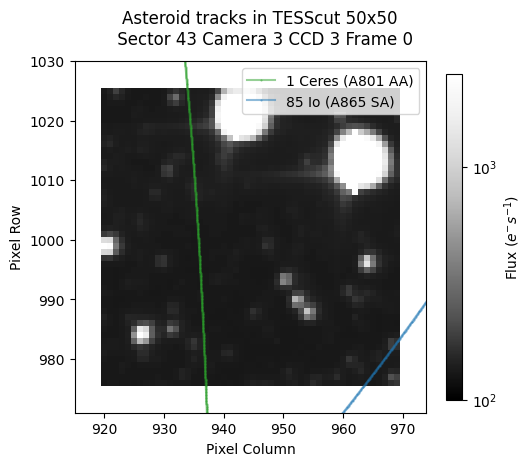

interactive(children=(IntSlider(value=83, description='frame', max=476, min=83, step=2), Output()), _dom_class…

In [82]:
frame = 0

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n Sector {sector} Camera {camera} CCD {ccd} Frame {frame}", 
             y=0.95)
ima = ax.pcolormesh(fficut_aster.column_2d, 
                        fficut_aster.row_2d,
                        fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=colors.SymLogNorm(linthresh=1000, vmin=100, vmax=2500, base=10),
                   )
plt.colorbar(
    ima, ax=ax, label=r"Flux ($e^{-}s^{-1}$)", fraction=0.042
    )

aperture_mask = fficut_aster.asteroid_mask[frame].reshape(fficut_aster.cutout_size, fficut_aster.cutout_size)
for i in range(aperture_mask.shape[0]):
    for j in range(aperture_mask.shape[1]):
        if aperture_mask[i, j]:
            rect = patches.Rectangle(
                xy=(j + fficut_aster.column.min() - 0.5, i + fficut_aster.row.min() - 0.5),
                width=1,
                height=1,
                color="tab:red",
                fill=False,
                hatch="",
                alpha=.5
            )
            ax.add_patch(rect)

ax.plot(sb_ephems_highres[0].column, 
         sb_ephems_highres[0].row, 
         ".-", 
         ms=1,
         c="tab:green", alpha=.5,
         label=jpl_sb_bright.loc[0, "Object name"])
ax.plot(sb_ephems_highres[1].column, 
         sb_ephems_highres[1].row,
         ".-", 
         ms=1,
         c="tab:blue", alpha=.5,
         label=jpl_sb_bright.loc[1, "Object name"])

ax.set_xlim(fficut_aster.column.min() - 5,fficut_aster.column.max() + 5)
ax.set_ylim(fficut_aster.row.min() - 5,fficut_aster.row.max() + 5)
ax.set_aspect("equal")
ax.set_xlabel("Pixel Column")
ax.set_ylabel("Pixel Row")
ax.legend()


@widgets.interact(frame=(time_idx.min()-5, time_idx.max()+5, 2))
def update(frame=0):
    ax.pcolormesh(fficut_aster.column_2d, 
                  fficut_aster.row_2d,
                  fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=colors.SymLogNorm(linthresh=1000, vmin=100, vmax=2500, base=10),
                   )
    aperture_mask = fficut_aster.asteroid_mask[frame].reshape(fficut_aster.cutout_size, fficut_aster.cutout_size)
    for i in range(aperture_mask.shape[0]):
        for j in range(aperture_mask.shape[1]):
            if aperture_mask[i, j]:
                rect = patches.Rectangle(
                    xy=(j + fficut_aster.column.min() - 0.5, i + fficut_aster.row.min() - 0.5),
                    width=1,
                    height=1,
                    color="tab:red",
                    fill=False,
                    hatch="",
                    alpha=.5
                )
                ax.add_patch(rect)
    
    fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n Sector {sector} Camera {camera} CCD {ccd} Frame {frame}", 
                y=0.95)
    return fig

plt.show()

In [239]:
fficut_aster.column_2d[:, 0]

array([920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
       933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945,
       946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958,
       959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969])

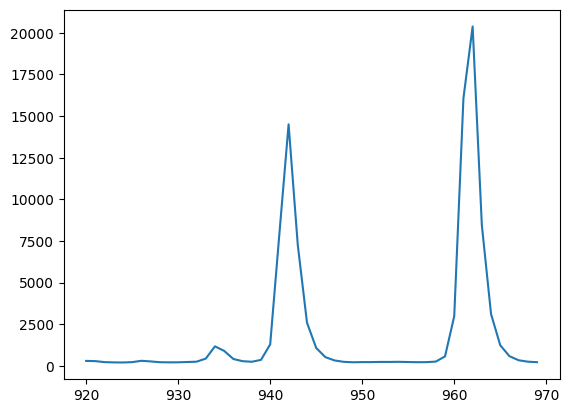

In [245]:
plt.plot(fficut_aster.column_2d[:, 0], fficut_aster.flux_2d[time_idx[50]].mean(axis=0));

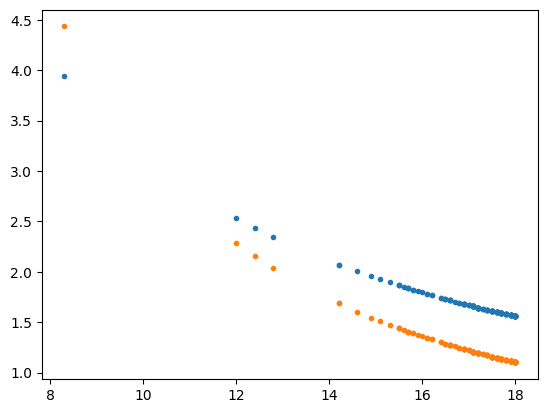

In [313]:
plt.plot(jpl_sb_bright.V_mag, 50 / (jpl_sb_bright.V_mag) ** 1.2, ".");
plt.plot(jpl_sb_bright.V_mag, 2e2 / (jpl_sb_bright.V_mag) ** 1.8, ".");

In [332]:
fficut_aster.asteroid_names.keys()

dict_keys([1, 2])

In [334]:
time_idx_s = {x: np.where((fficut_aster.asteroid_mask == x).any(axis=1))[0] for x in fficut_aster.asteroid_names.keys()}
time_idx_s

{1: array([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
        218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
        231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
        244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 

In [ ]:
np.where(fficut_aster.asteroid_mask.sum(axis=1) > 0)

In [221]:
fficut_aster.save_data()

In [222]:
test = np.load("/Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/tess-cut_asteroid_data_s0043-3-3_69.9079_15.8276_50x50pix.npz", allow_pickle=True)
test

In [223]:
list(test.items())

[('flux',
  array([[206.92223, 208.8444 , 208.24284, ..., 211.10237, 212.01588,
          213.85443],
         [204.98814, 206.95428, 206.80899, ..., 208.8637 , 207.43503,
          213.0044 ],
         [204.57031, 205.50748, 205.24484, ..., 207.56711, 205.96227,
          208.77342],
         ...,
         [633.31305, 641.063  , 638.14703, ..., 645.01764, 644.3675 ,
          649.55865],
         [645.03876, 649.8139 , 648.04407, ..., 657.99115, 656.66864,
          657.4127 ],
         [659.5675 , 662.52954, 662.5574 , ..., 669.4917 , 667.5271 ,
          670.2137 ]], dtype=float32)),
 ('mask',
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 ('time',
  array([2459474.17155629, 2459474.17850143, 2459474.18544657, ...,
         2459498.8751023 , 2459498.88204726, 2459498.88899221])),
 ('cbvs',
  array([[-0.00139444

{'xobs': '1.21079e+05,3.09662e+05,-3.77501e+04,-5.12984e-01,6.22680e-01,1.74236e-01'}